In [1]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
def replace_price_ticks(ax, xaxis, label):
    ticks = np.arange(0, 9e5, 1e5)
    labels = [str(int(round(t/1e3,0))) for t in ticks]
    if xaxis:
        ax.set_xticks(ticks, labels)
        ax.set_xlabel(f'{label} / 10$^3\\times$USD')
    else:
        ax.set_yticks(ticks, labels)
        ax.set_ylabel(f'{label} / 10$^3\\times$USD')

def convert_strings(num, base):
    length = int(np.floor(np.log10(num)))
    if length < base:
        s = '0'+str(round(num, -(base-2)))[:2]
    elif length == base:
        s = str(round(num, -(base-2)))[:3]
    else:
        raise ValueError('The length of the number to round is larger')
    return '{}.{}E+{:02d}'.format(s[0], s[1:], base)

error_text = '''\
- Average sale price: {}
- Mean absolute error: {}
- Median absolute error: {}
- Root mean squared error: {}
- R Squared: {:.4f}\
'''

In [3]:
dtypes = dict(MSSubClass=str)
df = pd.read_csv(os.path.join('data', 'ames-data-no-missing.csv'), index_col=0)

In [4]:
np.where(df.isnull().any())

(array([], dtype=int64),)

In [5]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
model = LassoCV(n_alphas=1000, eps=0.001, max_iter=10000)

In [9]:
model.fit(X_train_scaled, y_train)

LassoCV(max_iter=10000, n_alphas=1000)

In [10]:
model.alpha_

342.5806017461771

In [11]:
test_predictions = model.predict(X_test_scaled)
MAE = metrics.mean_absolute_error(y_test, test_predictions)
MSE = metrics.mean_squared_error(y_test, test_predictions)
RMSE = np.sqrt(MSE)
r2 = metrics.r2_score(y_test, test_predictions)
MedAE = metrics.median_absolute_error(y_test, test_predictions)
MAPerE = metrics.mean_absolute_percentage_error(y_test, test_predictions)
print(error_text.format(y_test.mean(), MAE, MSE, RMSE, MedAE, r2))

- Average actual price: 181122.35616438356
- Mean absolute error: 16327.898911475944
- Median absolute error: 621955596.2024827
- Root mean squared error: 24939.037595755028
- R2 score: 11531.6417


In [12]:
base = int(np.floor(np.log10(y_test.mean())))
str_vals = [convert_strings(y_test.mean(), base),
            convert_strings(MAE, base),
            convert_strings(MedAE, base),
            convert_strings(RMSE, base),
            r2]

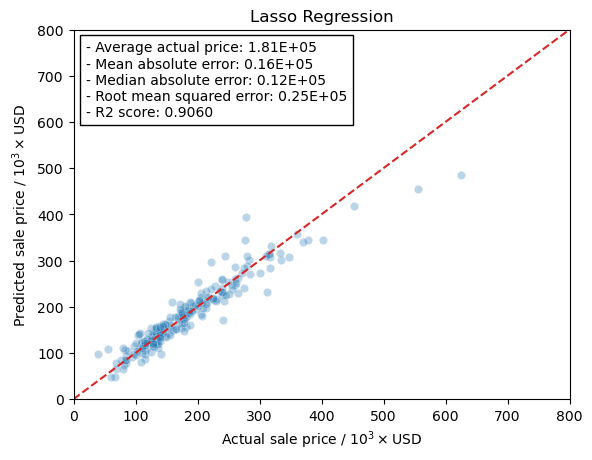

In [13]:
fig, ax = plt.subplots()
sns.scatterplot(x=y_test, y=test_predictions, alpha=0.3, ax=ax)
replace_price_ticks(ax, True, 'Actual sale price')
replace_price_ticks(ax, False, 'Predicted sale price')
ylim = ax.get_ylim()
xlim = ax.get_xlim()
new_lim = list(ylim)
if new_lim[0] > xlim[0]:
    new_lim[0] = xlim[0]
if new_lim[1] < xlim[1]:
    new_lim[1] = xlim[1]
ax.set_ylim(new_lim)
ax.set_xlim(new_lim)
ax.plot(new_lim, new_lim, color='tab:red', linestyle='--')
ax.text(s=error_text.format(*str_vals),
        x=0.025, y=0.97, transform=ax.transAxes, ha='left', va='top',
        bbox=dict(fc="none"))
ax.set_title('Lasso Regression')
fig.savefig(os.path.join('figures', 'lasso.png'), dpi=500)